# What precision does UMAP needs for good clustering?

We study the impact of UMAP's parameter n_epochs on the HDBSCAN clustering task. We wish to see what portion of the work performed by UMAP is needed for enabling cluster identification. Note that the initial embedding of the points is the spectral embedding of the graph's normalized Laplacian.

In [2]:
!git branch

* main


In [3]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [4]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

from partition_igraph import community_ecg as ecg
from community import community_louvain, modularity
import leidenalg as la
import igraph as ig

sns.set()

In [5]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [6]:
def evaluation_dataframe(cluster_labels, true_labels, raw_data, min_cluster_size=1):
    eval_results = pd.DataFrame(
        [
            eval_clusters(algo_labels, true_labels, raw_data, cluster_method=algo, min_cluster_size=min_cluster_size)
            for algo, algo_labels in cluster_labels.items() 
        ]
    )
    return(eval_results)

In [7]:
def eval_clusters(cluster_labels0, true_labels, raw_data, cluster_method="None", min_cluster_size=1):
    cluster_labels = cluster_labels0.copy()
    unique_labels = np.unique(cluster_labels)
    cluster_sizes, size_ids = np.histogram(cluster_labels, bins=unique_labels)
    if np.any(cluster_sizes <= min_cluster_size): # Has singleton clusters -- call them noise
        singleton_clusters = size_ids[:-1][cluster_sizes < min_cluster_size]
        for c in singleton_clusters:
            cluster_labels[cluster_labels == c] = -1
    if (np.any(cluster_labels < 0)): # Has noise points
        clustered_points = (cluster_labels >= 0)
        ari = adjusted_rand_score(true_labels[clustered_points], cluster_labels[clustered_points])
        ami = adjusted_mutual_info_score(true_labels[clustered_points], cluster_labels[clustered_points])
        sil = silhouette_score(raw_data[clustered_points], cluster_labels[clustered_points])
        pct_clustered = (np.sum(clustered_points) / cluster_labels.shape[0])
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}\nPct clustered: {pct_clustered * 100:.2f}%")
    else:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ami = adjusted_mutual_info_score(true_labels, cluster_labels)
        sil = silhouette_score(raw_data, cluster_labels)
        #print(f"ARI: {ari:.4f}\nAMI: {ami:.4f}\nSilhouette: {sil:.4f}")
        pct_clustered = 1.0
    
    return {"Method": cluster_method, "ARI": ari, "AMI": ami, "Silhouette": sil, "Pct Clustered": pct_clustered}

In [8]:
def plot_scores(results_dataframe, score_types=("ARI", "AMI"), colors=list(sns.color_palette()), width=0.75, by='Dim Reduction', baselines=None):
    if(baselines is not None):
        if(len(score_types)!=len(baselines)):
            raise ValueError('Need to same length for score_types and baselines')
    else:
        baselines = [0]*len(score_types)
    fig, axs = plt.subplots(1, len(score_types), figsize=(8 * len(score_types), 8))
    x_ticklabels = results_dataframe.Method.unique()
    x_positions = np.arange(len(x_ticklabels), dtype=np.float32) - width / 2
    dim_red_types = results_dataframe[by].unique()
    bar_width = width / len(dim_red_types)
    for offset_idx, dim_red in enumerate(dim_red_types):
        color = colors[offset_idx]
        for i, score_type in enumerate(score_types):
            sub_dataframe = results_dataframe[
                (results_dataframe["Score Type"] == score_type) &
                (results_dataframe[by] == dim_red)
            ]
            nb_method = sub_dataframe.shape[0]
            axs[i].bar(
                x=x_positions[:nb_method],
                height=sub_dataframe["Score"],
                width=bar_width,
                align="edge",
                color=[(*color, v) for v in sub_dataframe["Pct Clustered"]],
                label=dim_red if i ==0 else None,
            )
            axs[i].set_xlabel("Cluster Method")
            axs[i].set_xticks(np.arange(len(x_ticklabels)))
            axs[i].set_xticklabels(x_ticklabels)
            axs[i].set_ylabel(f"{score_type} Score")
            axs[i].set_title(score_type, fontsize=20)
            axs[i].grid(visible=False, axis="x")
            axs[i].set_ylim([0, 1.05])
        x_positions[:nb_method] = x_positions[:nb_method] + bar_width
        x_positions[nb_method:] = x_positions[nb_method:] + 0.5*bar_width
    for i in range(len(score_types)):
        axs[i].axhline(baselines[i])
        
    if len(dim_red_types) > 1:
        fig.legend(loc="center right", bbox_to_anchor=(1.125, 0.5), borderaxespad=0.0, fontsize=20)
        
    fig.tight_layout()

# Exploration

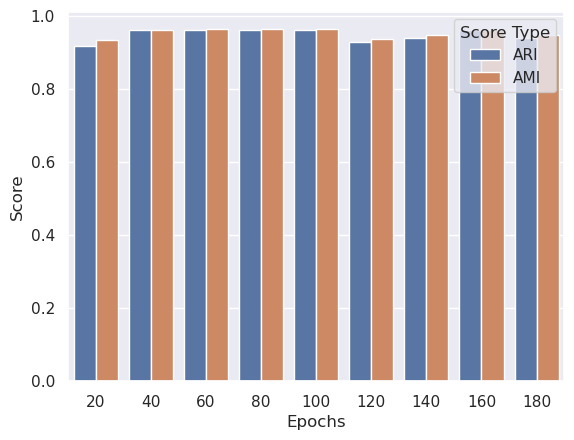

In [9]:
dataset_id = 0
params = get_dataset_params(dataset_id)
raw_data, targets, dataset_name = get_dataset(dataset_id)
umap_results = []
for n_epochs in range(20,200,20):
    umap_rep = umap.UMAP(n_neighbors=params['n_neighbors'],
                             n_components=params['n_components'], 
                             min_dist=params['min_dist'], 
                             random_state=params['random_state'],
                        n_epochs = n_epochs).fit_transform(raw_data)
    hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
    umap_results_part = evaluation_dataframe({'HDBSCAN':hd_umap_labels}, targets, raw_data)
    umap_results_part['Epochs'] = n_epochs
    umap_results.append(umap_results_part)

results = pd.concat(umap_results)
results_long = results.melt(["Method", "Pct Clustered", 'Epochs'], var_name="Score Type", value_name="Score")
sns.barplot(data=results_long[results_long['Score Type']!='Silhouette'], x='Epochs', y='Score',  hue='Score Type')
plt.show()    

In [13]:
def varying_n_epochs(dataset_id, w_range, k_fold=1):
    params = get_dataset_params(dataset_id)
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))    
    
    umap_results = []
    for n_epochs in w_range:
        for i in range(k_fold):
            umap_rep = umap.UMAP(n_neighbors=params['n_neighbors'],
                                     n_components=params['n_components'], 
                                     min_dist=params['min_dist'], 
                                n_epochs = n_epochs).fit_transform(raw_data)
            hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
            umap_results_part = evaluation_dataframe({'HDBSCAN':hd_umap_labels}, targets, raw_data)
            umap_results_part['Epochs'] = n_epochs
            umap_results.append(umap_results_part)

    results = pd.concat(umap_results)
    results_long = results.melt(["Method", "Pct Clustered", 'Epochs'], var_name="Score Type", value_name="Score")
    barplot = sns.barplot(data=results_long[results_long['Score Type']!='Silhouette'], x='Epochs', y='Score',  hue='Score Type')
    barplot.set_ylim([0, 1.05])
    plt.gcf().tight_layout()
    plt.savefig(F'figures/nepochs_{dataset_name}.png')
    plt.show()

## pendigits

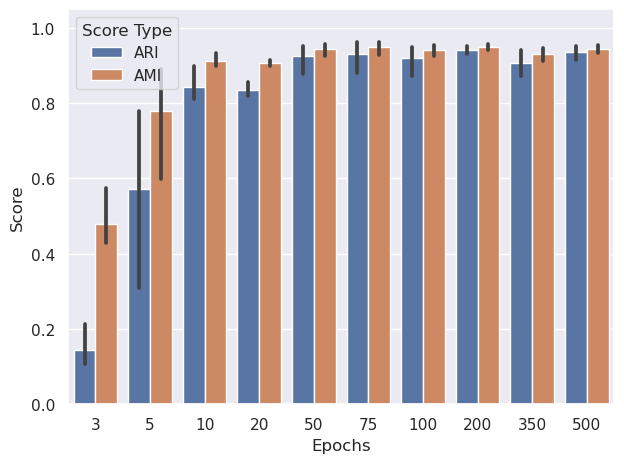

## coil

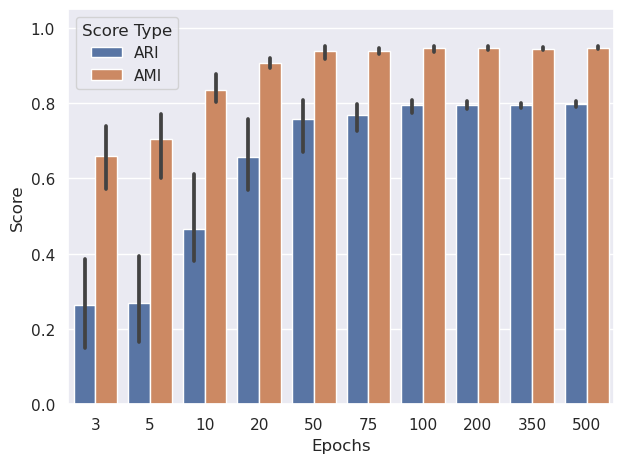

## mnist

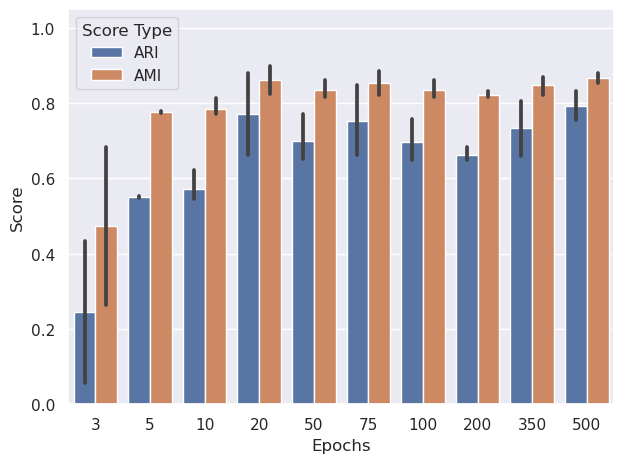

## usps

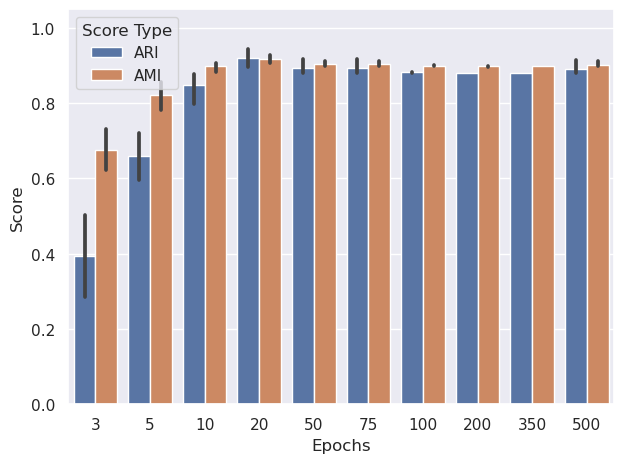

## buildings

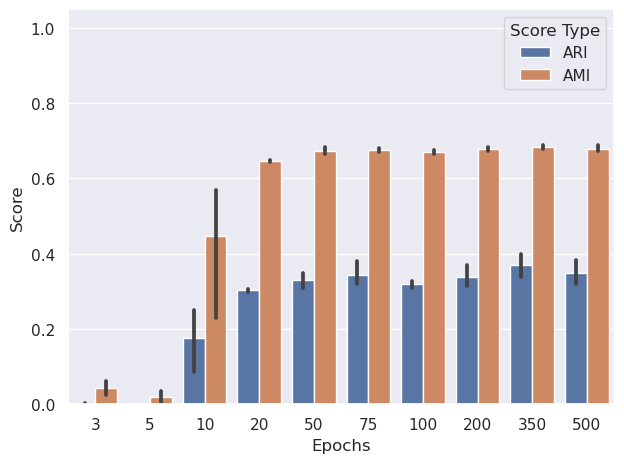

In [14]:
import warnings
warnings.filterwarnings('ignore')
for i in range(5):
    varying_n_epochs(dataset_id=i, w_range= [3, 5, 10, 20, 50, 75, 100, 200, 350, 500], k_fold=5)